# Signal Integrity Analysis of a 100 Gbps Transmitter

High-speed optical modulators, operating at data rates of >100 Gbps per wavelength channel, requires careful attention to their time-domain response, since bandwidth limitations, dispersion, and non-ideal modulator transfer characteristics can degrade signal integrity and increase bit-error rates.


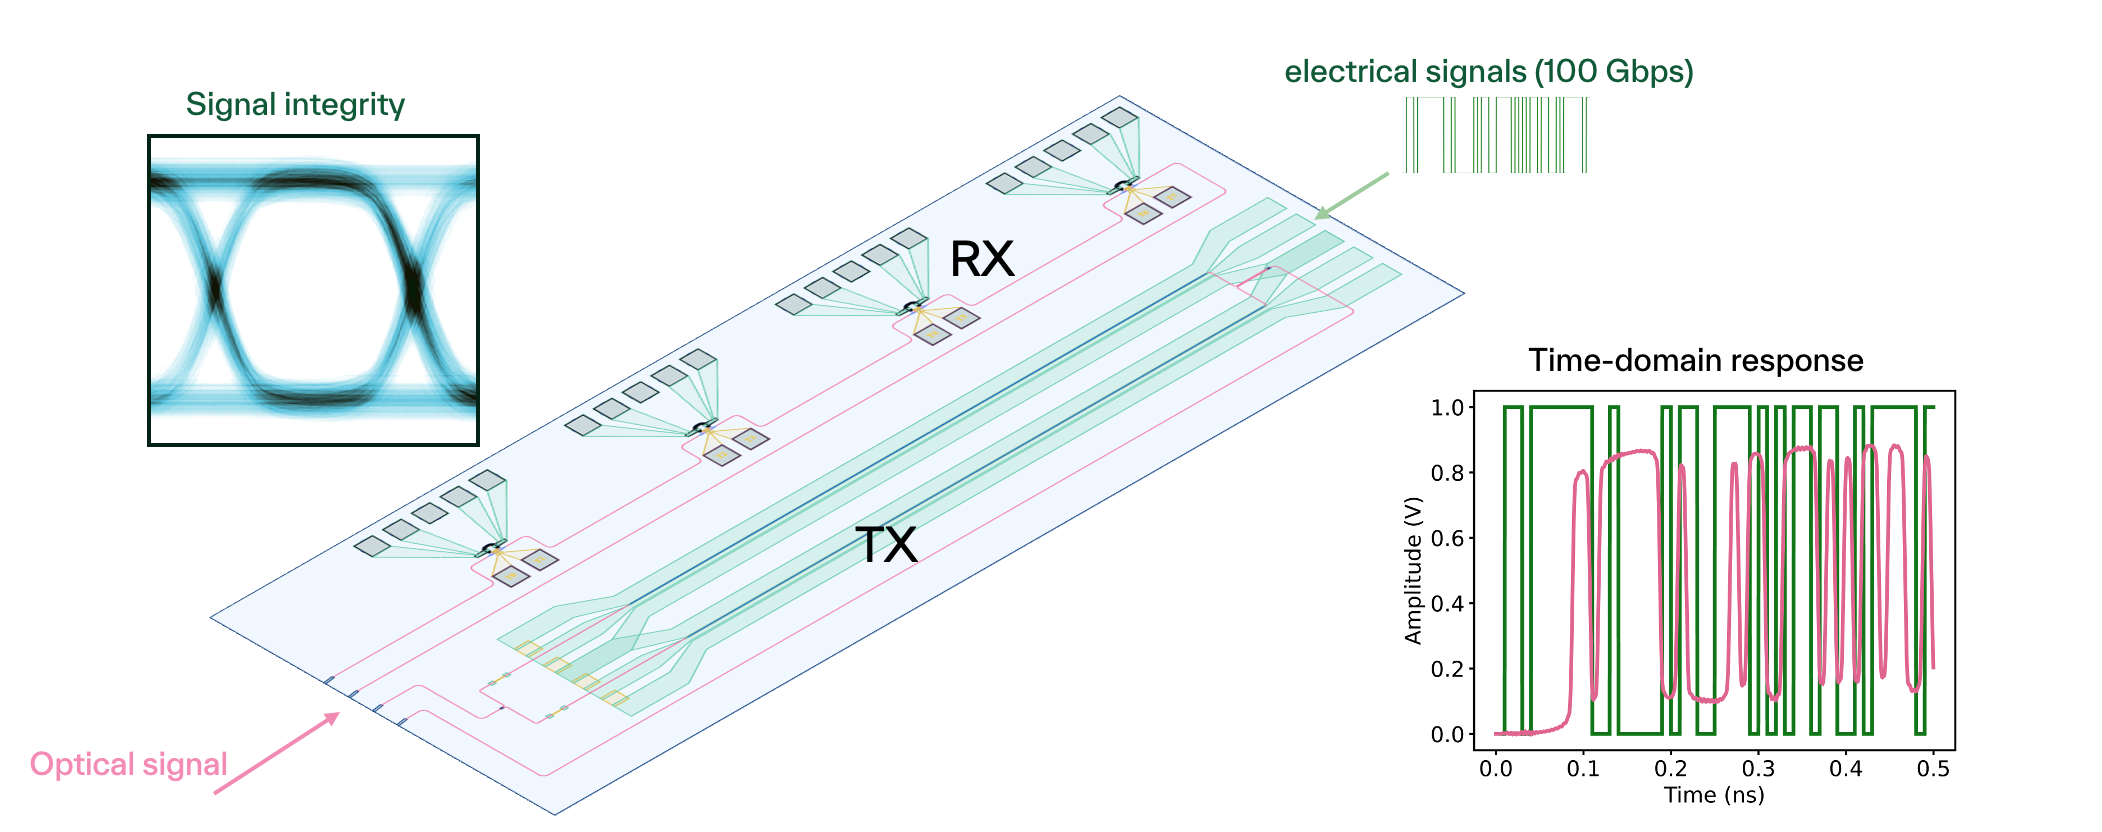

To evaluate quality of modulated signal in these systems, eye-diagram measurements are usually performed to visualize how the modulated signal evolves over time and reveal timing jitter, distortion, and noise margins.

Using PhotonForge, you can use scattering parameters to build a compact time-domain model of your component to analyze signal integrity, anticipate performance bottlenecks, and optimize design parameters before committing to costly fabrication.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
from scipy.signal import bessel, filtfilt

## High-speed modulator transfer function

To begin, we will start by creating an electro-optic transfer function. In principle, it is also possible to simply load experimentally measured EO S21 data as a transfer function. 

For a traveling-wave electro-optic modulator in thin-film lithium niobate, the frequency response (EO S21) of a modulator follows the following analytical expression [ref 1]

$$
m(\omega) = \left| \frac{2Z_{\text{in}}}{Z_{\text{in}} + Z_L}\right| \left|\frac{(Z_L + Z_0) F_+ + (Z_L - Z_0) F_- }{(Z_L + Z_0) e^{\gamma m_L} + (Z_L - Z_0) e^{-\gamma m_L}}\right|
$$

in which $\omega = 2\pi f$ is the angular frequency of the microwave signal, $Z_{in} = Z_0 \frac{Z_L+Z_0*tanh(\gamma_mL)}{Z_0+Z_L*tanh(\gamma_m L)}$ is the input impedance of the transmission line, $F_{\pm} = (1-e^{})/(\pm \gamma_m L - j (\omega/c) n_{g,opt} L)$ which accounts for forward/backward propagating waves with propagation constant $\gamma_m = \alpha_m + j (\omega/c)  n_m$. Here, $n_m$ being the microwave effective index, $\alpha_m$ the loss rate and $n_{g,opt}$ is the optical group index, $L$ is the length of the modulator, $c$ is the speed of light in vacuum, $Z_L$ is the load impedance, and $Z_0$ is the characteristic impedance of the transmission line. 

**Reference:** Zhu, Di, et al. "Integrated photonics on thin-film lithium niobate." Advances in Optics and Photonics 13.2 (2021): 242-352.

In [2]:
# Define a modulator transfer function
def Mw(alpha, freq_GHz, n_m, n_o, L_cm, Z_L, Z_0):
    L = L_cm * 1e-2
    alpha_m = alpha / (20 * np.log10(np.exp(1))) * np.sqrt(freq) * 1 / 1e-2
    c = 299792458
    omega = -2 * np.pi * freq * 1e9
    gamma_m = alpha_m + 1j * omega / c * n_m

    F_plus = (1 - np.exp(gamma_m * L - 1j * omega / c * n_o * L)) / (
        gamma_m * L - 1j * omega / c * n_o * L
    )
    F_minus = (1 - np.exp(-gamma_m * L - 1j * omega / c * n_o * L)) / (
        -gamma_m * L - 1j * omega / c * n_o * L
    )
    Z_in = Z_0 * (Z_L + Z_0 * np.tanh(gamma_m * L)) / (Z_0 + Z_L * np.tanh(gamma_m * L))

    m_w = (
        (2 * Z_in / (Z_in + Z_L))
        * ((Z_L + Z_0) * F_plus + (Z_L - Z_0) * F_minus)
        / ((Z_L + Z_0) * np.exp(gamma_m * L) + (Z_L - Z_0) * np.exp(-gamma_m * L))
    )

    return m_w

We can use our RF and optical solver to estimate these parameters like optical and RF indices, impedances, and also loss. Please refer to our notebook on designing [electro-optic Mach-Zehnder Modulator](EO-MZM.ipynb).

In [3]:
# Initialize parameters with some nominal values
freq = np.logspace(-1, 2.5, 1001)  # GHz

alpha = 0.75  # dB/cm/sqrt(GHz) Transmission line loss in dB/cm/sqrt(GHz)
n_m = 2.25  # microwave index
n_o = 2.32  # optical group index
L_cm = 1  # modulator length
Z_L = 50  # Assume 50 ohm termination load
Z_0 = 40  # Characteristic impedance of the tranmission line

# Electro-optic S21 calculated analytically
# In reality this will be some measured data but this is good enough for now
EOS21 = Mw(alpha, freq, n_m, n_o, L_cm, Z_L, Z_0)

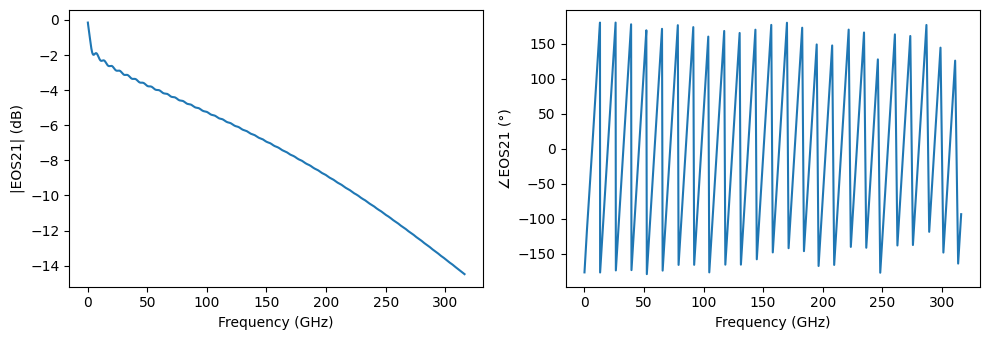

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)

ax[0].plot(freq, 10 * np.log10(np.abs(EOS21) ** 2))
ax[0].set(xlabel="Frequency (GHz)", ylabel="|EOS21| (dB)")

ax[1].plot(freq, np.angle(EOS21, deg=True))
_ = ax[1].set(xlabel="Frequency (GHz)", ylabel="∠EOS21 (°)")

## Building a time-domain model

Let's first create a S-matrix representation in PhotonForge using the [pole_residue_fit](../_autosummary/photonforge.pole_residue_fit.rst) function.

/tmp/ipykernel_653290/3832004301.py:6: RuntimeWarning: Desired RMS error tolerance not reached: 0.005961749028773892.
  pole_res, err = pf.pole_residue_fit(


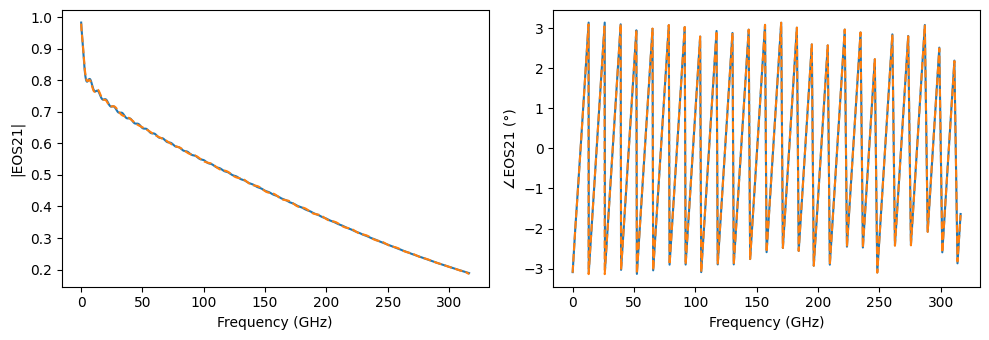

In [5]:
baseband_freqs = freq * 1e9
elements = {("1", "2"): EOS21}
s_matrix = pf.SMatrix(frequencies=baseband_freqs, elements=elements)

# User vector fitting to fit the transfer function before building the time-domain model
pole_res, err = pf.pole_residue_fit(
    s_matrix,
    delays=None,
    real=True,
    min_poles=30,
    max_poles=60,
)
s_fit = pole_res(baseband_freqs)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)

ax[0].plot(freq, np.abs(EOS21))
ax[0].plot(freq, np.abs(s_fit["1", "2"]), "--")
ax[0].set(xlabel="Frequency (GHz)", ylabel="|EOS21|")

ax[1].plot(freq, np.angle(EOS21))
ax[1].plot(freq, np.angle(s_fit["1", "2"]), "--")
_ = ax[1].set(xlabel="Frequency (GHz)", ylabel="∠EOS21 (°)")

We see a warning about the RMS error tolerance for the fit.
That is because the default tolerance is 1.0×10⁻⁴ (a very conservative value) and the fit reached 5.96×10⁻³.
Nonetheless, we can see in the plot that all major features of the transfer function are captured, so we can move forward with this result.

## PRBS Signal Generation

Next, we will generate the input electrical signal at 100 Gbps that would be applied to the modulator.

In [6]:
# Define parameters
bit_rate = 100e9  # Bit rate (bps)
T = 1 / bit_rate  # Bit period (s)
num_bits = 1000  # Number of bits in PRBS sequence
V = 1  # peak driving voltage

# Desired samples per bit for smoother eye diagram
samples_per_bit = 100
Fs = samples_per_bit * bit_rate  # Sampling frequency
time_step = 1 / Fs  # Time step for simulation

# Time vector
t = np.arange(0, num_bits * T, time_step)

# Generate PRBS sequence
np.random.seed(0)  # For reproducibility
prbs_bits = np.random.randint(0, 2, num_bits)

# Generate NRZ signal
ideal_prbs_signal = np.repeat(prbs_bits, samples_per_bit)
ideal_prbs_signal = V * ideal_prbs_signal[: len(t)]

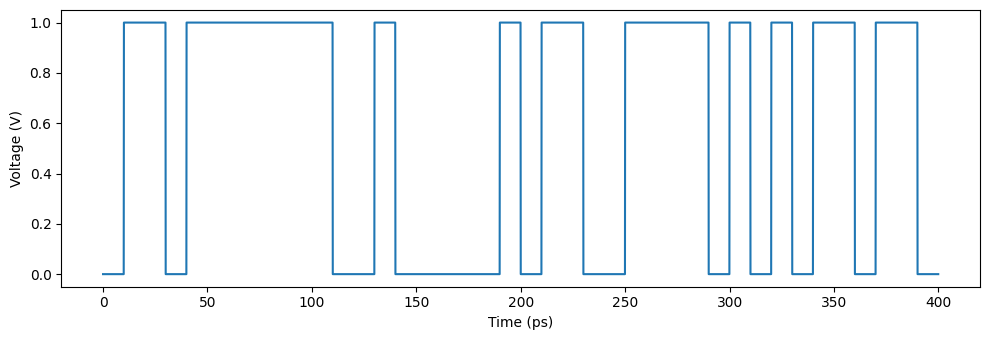

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), tight_layout=True)
ax.plot(t[:4000] * 1e12, ideal_prbs_signal[:4000])
_ = ax.set(xlabel="Time (ps)", ylabel="Voltage (V)")

Real electrical systems have some high-frequency cutoff so the signals will not have sharp transitions like we generate above.
In simulation, we must also guarantee that the major frequency components of the input signal fall within the valid region in our model, which was fitted up to 300 GHz.

Therefore, we'll pipe the ideal signal through a 200 GHz low-pass-filter to generate the real electrical input.

In [8]:
cutoff_freq = 200e9  # 200 GHz
filter_order = 4

# Normalize the frequency
nyquist_freq = 0.5 * Fs
normalized_cutoff = cutoff_freq / nyquist_freq

# Design Bessel filter
b, a = bessel(N=filter_order, Wn=normalized_cutoff, btype="low", analog=False)

# Apply the filter
real_prbs_signal = filtfilt(b, a, ideal_prbs_signal)

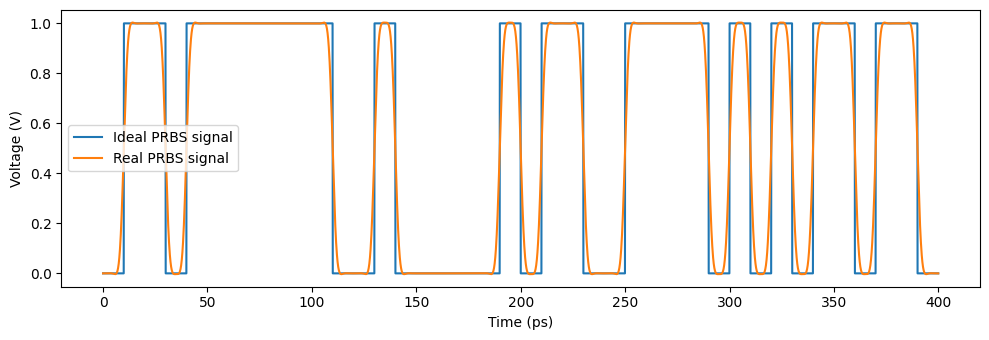

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), tight_layout=True)
ax.plot(t[:4000] * 1e12, ideal_prbs_signal[:4000], label="Ideal PRBS signal")
ax.plot(t[:4000] * 1e12, real_prbs_signal[:4000], label="Real PRBS signal")
ax.set(xlabel="Time (ps)", ylabel="Voltage (V)")
_ = plt.legend()

## Build a time domain model

First use the frequency response to build a [time-domain model](../_autosummary/photonforge.TimeDomainModel.rst).

In [10]:
time_domain_model = pf.TimeDomainModel(pole_res, time_step)

Now, time-step to generate output optical signal as a function of time

In [11]:
optical_signal = np.zeros(len(t))
for i in range(len(t)):
    outputs = time_domain_model.step({"1": real_prbs_signal[i]})
    optical_signal[i] = np.abs(outputs["2"])

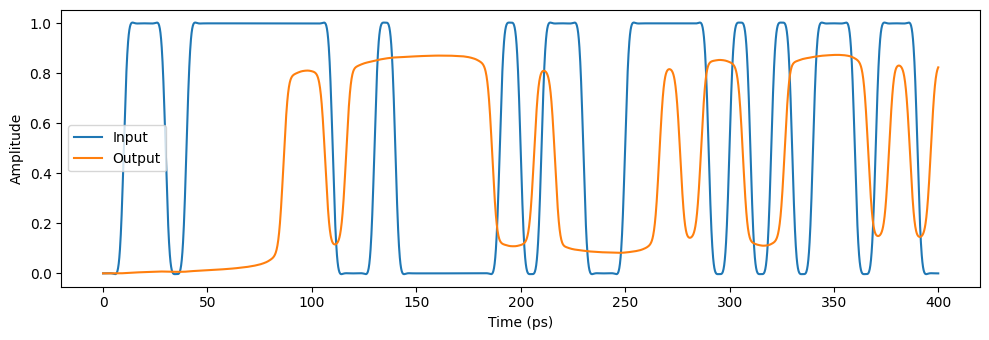

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), tight_layout=True)
ax.plot(t[:4000] * 1e12, real_prbs_signal[:4000], label="Input")
ax.plot(t[:4000] * 1e12, optical_signal[:4000], label="Output")
ax.set(xlabel="Time (ps)", ylabel="Amplitude")
_ = plt.legend()

We can use the full sample extent to build an eye diagram.

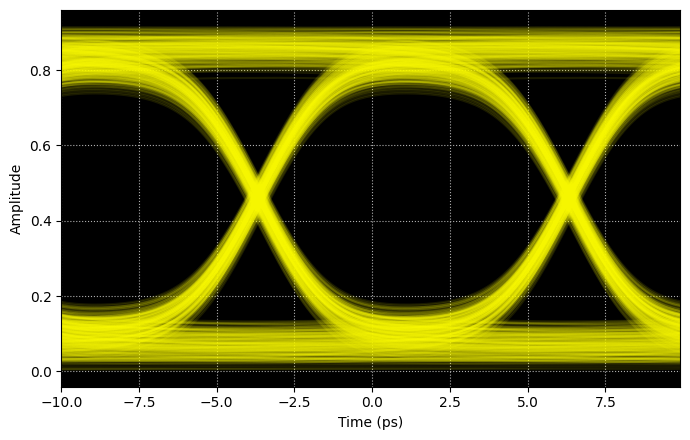

In [13]:
def plot_eye_diagram(optical_output_signal, bit_rate, time_step):
    Fs = 1 / time_step  # sampling frequency
    samples_per_bit = int(0.5 + Fs / bit_rate)

    # Calculate window parameters
    samples_per_window = 2 * samples_per_bit  # 2T window
    start_index = samples_per_window  # Skip initial transients

    # Calculate number of windows
    num_windows = (
        len(optical_output_signal)
        - start_index
        - (samples_per_window - samples_per_bit)
    ) // samples_per_bit
    if num_windows <= 0:
        raise ValueError("Output signal is too short to generate eye diagram.")

    # Extract signal segments for the eye diagram
    parts = []
    for k in range(num_windows):
        idx_start = start_index + k * samples_per_bit
        idx_end = idx_start + samples_per_window
        part = optical_output_signal[idx_start:idx_end]
        parts.append(part)

    parts = np.array(parts).T  # Transpose for time on x-axis

    # Time vector for plotting (centered around 0, in nanoseconds)
    t = (np.arange(samples_per_window) - samples_per_bit) * time_step * 1e12

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(7, 4.5), tight_layout=True)
    ax.plot(t, parts, color="yellow", alpha=0.1)
    ax.set(xlabel="Time (ps)", ylabel="Amplitude", facecolor="k", xlim=(t[0], t[-1]))
    ax.grid(ls=":")


plot_eye_diagram(optical_signal, bit_rate, time_step)

Since this modulator has relatively high bandwidth, it can support high speed modulation and you an see clear eye-opening for this 100 Gbps non-return-to-zero (NRZ) signal.